# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


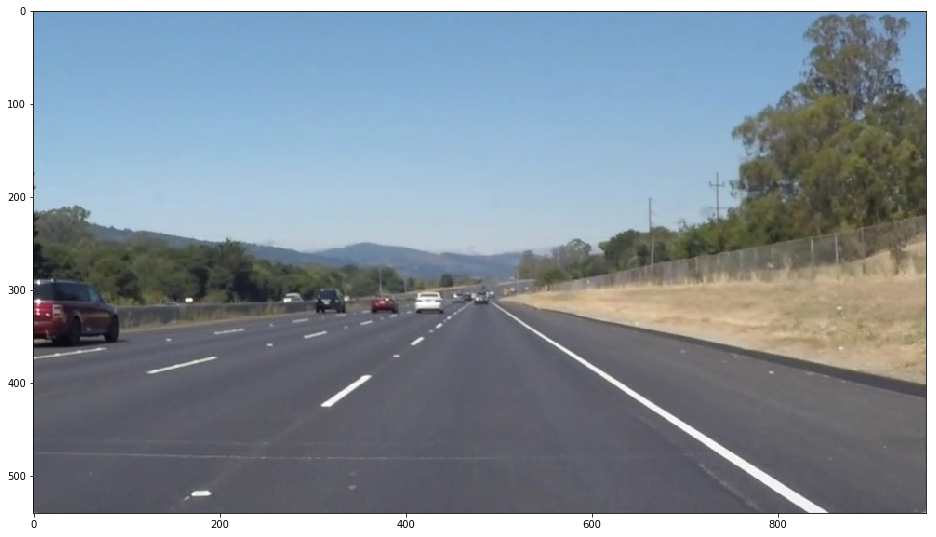

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #b,g,r = cv2.split(im)
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    ym,xmax,depth = img.shape
    ybottom = ym
    ytop = int(ybottom *.6)
    lc = 0
    rc = 0
    ltx = lbx = rbx = rtx = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (y1>y2):
                t = (x1, y1)
                x1,y1 = (x2,y2)
                x2,y2 = t
            m = ((y2-y1)/(x2-x1))
            if (.75-abs(m)<.3):
                line_bottomx = -((ybottom - y2)/-m) + x2
                line_topx = -((y2 - ytop)/m) + x2
                #print (m)
                if (m>0):
                    lbx = lbx + line_bottomx
                    ltx = ltx + line_topx
                    lc = lc +1
                else:
                    rbx = rbx + line_bottomx 
                    rtx = rtx + line_topx
                    rc = rc + 1 
    
    if (lc > 0):
        ltx = int(ltx / lc)
        lbx = int(lbx / lc)
        cv2.line(img, (ltx, ytop), (lbx, ybottom), color, thickness)
    if (rc > 0):
        rbx = int(rbx / rc)
        rtx = int(rtx / rc)
        if (rbx <0):
            rbx = abs(rbx)
        if (rtx<0):
            rtx = -rtx
        cv2.line(img, (rtx, ytop), (rbx, ybottom), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def hough_linesd(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = ((y2-y1)/(x2-x1))
            if (.75-abs(m)<.3):
                cv2.line(line_img, (x1, y1), (x2, y2), [255, 255, 0], 2)
    return line_img
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline


(540, 960, 3)


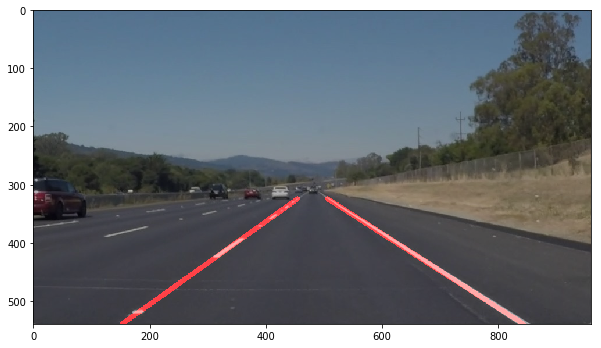

In [4]:
def f_img(image):
    y,x,d = image.shape
    region = np.array([[[0,y],[x,y], [x/2, y/2+30]]], dtype=np.int32 )
    
#    return weighted_img(image,hough_lines(canny(gaussian_blur(grayscale(image), 7), 5, 255), 1,np.pi/180*1,30,100,120),1,.7)
    return weighted_img(image,hough_lines(region_of_interest(canny(gaussian_blur(grayscale(image), 7), 5, 155),region), 1,np.pi/180*1,30,100,120),1,.7)


plt.rcParams['figure.figsize'] = (10, 6)
print(image.shape)
plt.imshow(f_img(image))

In [5]:
def imwrite(file, image):
    image = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(file, image)
    
#im = mpimg.imread('test_images/grayTarYellowLine.jpg')
def prepareWriteupImages():
    im=image
    y,x,d = im.shape
    region = np.array([[[0,y],[x,y], [x/2, y/4+20]]], dtype=np.int32 )
    plt.rcParams['figure.figsize'] = (5, 3)
    b,g,r = cv2.split(im)
    plt.imshow(grayscale(im), cmap='gray')
    imwrite("examples/imageGray.jpg",grayscale(im))
    imwrite("examples/imageBlur.jpg",gaussian_blur(grayscale(im),7))
    imwrite("examples/imageCanny.jpg",canny(gaussian_blur(grayscale(im),7), 13,155))
    imwrite("examples/imageClipped.jpg",region_of_interest(canny(gaussian_blur(grayscale(im),7), 13,155), region))
    plt.show()
    plt.imshow(r, cmap='gray')
    plt.show()

    plt.imshow(region_of_interest(canny(gaussian_blur(r, 7), 5, 255),region))
    plt.show()
    h_img = hough_linesd(region_of_interest(canny(gaussian_blur(r, 7), 13, 155),region), 1,np.pi/180*1,30,100,120)
    plt.imshow(h_img)
    imwrite("examples/imageHough.jpg",h_img)
    plt.show()
    plt.imshow(f_img(im))
    imwrite("examples/imageFinal.jpg",f_img(im))

#prepareWriteupImages()    

In [10]:
import os
files = os.listdir("test_images/")

Image shadowYellowLine.jpg


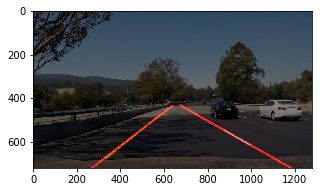

Image solidWhiteCurve.jpg


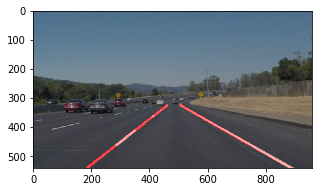

Image solidWhiteRight.jpg


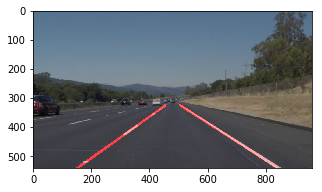

Image solidYellowCurve.jpg


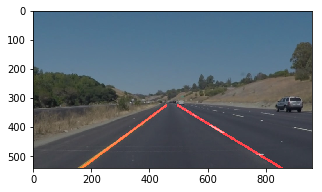

Image solidYellowCurve2.jpg


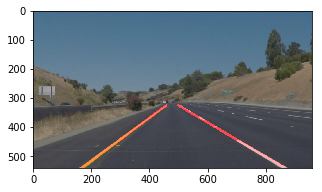

Image solidYellowLeft.jpg


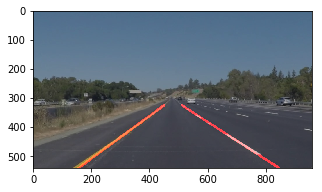

Image whiteCarLaneSwitch.jpg


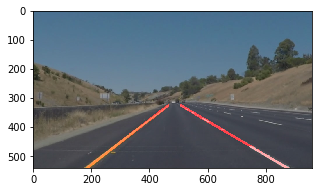

In [14]:
plt.rcParams['figure.figsize'] = (5, 3)
for fl in files:
    im = mpimg.imread("test_images/%s"%fl)
    print("Image %s"%fl)
    output = f_img(im)
    imwrite("test_images_output/%s"%fl, output)
    plt.imshow(output)
    plt.show()

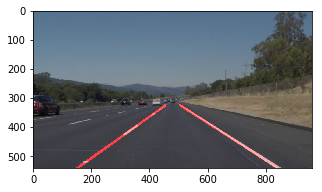

In [12]:
im = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(f_img(im))

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test on Videos


In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return f_img(image)

Let's try the one with the solid white lane on the right first ...

In [18]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:08<00:00, 26.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.38 s, sys: 470 ms, total: 3.85 s
Wall time: 9.34 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [20]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:27<00:00, 25.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.6 s, sys: 930 ms, total: 11.5 s
Wall time: 28.2 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup 

Here is the [project writeup](https://github.com/dileepbapat/SelfDriveCar-LaneDetection/blob/master/writeup.md) 


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [22]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:20<00:00, 13.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.13 s, sys: 600 ms, total: 7.73 s
Wall time: 23 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}?a">
</video>
""".format(challenge_output))